# Run this only once to extract the image files.
- Use the below code when you have the zip and you want to extract it.
```
    import zipfile as zp
    zipExtract = zp.ZipFile('./dataSample.zip','r')
    zipExtract.extractall('./')
    zipExtract.close()
```

In [2]:
#Import Required Libraries

%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import  datasets,models, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os

In [3]:
# Define the data directories - Replace them with your train,test and validation dataset.
data_directory = 'dataset2-master/images/'
train_dir = data_directory + 'TRAIN/'
valid_dir = data_directory + 'TEST/'
test_dir = data_directory + 'TEST_SIMPLE/'

train_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                        transforms.ToTensor(),
                                       transforms.Normalize([0.5,0.5,0.5], 
                                                            [0.5,0.5,0.5])])
testval_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,0.5,0.5], 
                                                            [0.5,0.5,0.5])])

image_trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
image_testset = datasets.ImageFolder(test_dir, transform=testval_transforms)
image_valset = datasets.ImageFolder(valid_dir, transform=testval_transforms)

image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=20, shuffle=True)
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=20, shuffle=True)
image_valloader = torch.utils.data.DataLoader(image_valset, batch_size=20, shuffle=True)

In [4]:
classes = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

In [5]:
def imshow(image, predicted=None, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

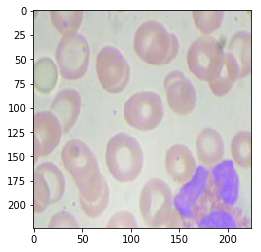

In [6]:
dataiter = iter(image_testloader)
images, labels = next(dataiter)
images = images # convert images to numpy for display

imshow(images[0])

In [7]:
#checking the first element in the labels batch
labels

tensor([0, 3, 3, 3, 3, 0, 1, 3, 0, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 0])

In [8]:
image_trainset.class_to_idx

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [9]:
(image_trainset.classes)[labels[0]]

'EOSINOPHIL'

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [11]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [12]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 784)
        self.fc2 = nn.Linear(784, 196)
        self.fc3 = nn.Linear(196, 4)
        self.dropout = nn.Dropout(0.25)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

model = NeuralNet()
print(model)


# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

NeuralNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=4, bias=True)
  (dropout): Dropout(p=0.25)
  (softmax): LogSoftmax()
)


In [44]:
#Criterion
criterion = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [45]:

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in image_trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # Validation Stage
    model.eval()
    for data, target in image_valloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(image_trainloader.dataset)
    valid_loss = valid_loss/len(image_valloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'saveCheck3.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.385542 	Validation Loss: 1.384961
Validation loss decreased (inf --> 1.3850).  Saving model ...
Epoch: 2 	Training Loss: 1.383386 	Validation Loss: 1.380204
Validation loss decreased (1.3850 --> 1.3802).  Saving model ...
Epoch: 3 	Training Loss: 1.371312 	Validation Loss: 1.338078
Validation loss decreased (1.3802 --> 1.3381).  Saving model ...
Epoch: 4 	Training Loss: 1.296933 	Validation Loss: 1.204000
Validation loss decreased (1.3381 --> 1.2040).  Saving model ...
Epoch: 5 	Training Loss: 1.200013 	Validation Loss: 1.075516
Validation loss decreased (1.2040 --> 1.0755).  Saving model ...
Epoch: 6 	Training Loss: 1.136483 	Validation Loss: 1.093840
Epoch: 7 	Training Loss: 1.071235 	Validation Loss: 1.031107
Validation loss decreased (1.0755 --> 1.0311).  Saving model ...
Epoch: 8 	Training Loss: 1.014894 	Validation Loss: 1.010419
Validation loss decreased (1.0311 --> 1.0104).  Saving model ...
Epoch: 9 	Training Loss: 0.944451 	Validation Loss: 1.146707

In [13]:
model.load_state_dict(torch.load('saveCheck2.pt'))

In [14]:
def process_image(image):
    image_PIL = Image.open(image)
    
    image_modifications = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
    
    image_tensor = image_modifications(image_PIL) #Applying transforms on the image
    
    return image_tensor

image_proccessed = process_image(test_dir + "/EOSINOPHIL/_0_5239.jpeg")


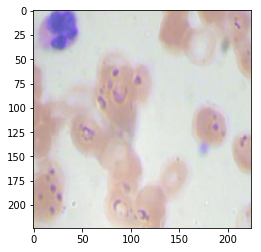

In [15]:
imshow(image_proccessed)

In [16]:
def predict(image_path, model):
    model.eval()
    image_predict_processed = process_image(image_path)
    processed = image_predict_processed.unsqueeze(0).cuda()
    with torch.no_grad():
        output = model.forward(processed)
    prob = torch.exp(output)
    predict_cpu_value = prob.cpu()
    predicted_type_index = torch.argmax(predict_cpu_value).item()
    predicted = classes[predicted_type_index]
    if predicted in [classes[1],classes[2]]:
        print(predicted,'Mononuclear')
    else:
        print(predicted,'Polynuclear')
    imshow(image_predict_processed,predicted)
    plt.figure()
    plt.bar(classes,predict_cpu_value[0].numpy())
    plt.show()
    
    return predicted

EOSINOPHIL Polynuclear


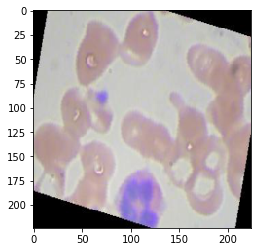

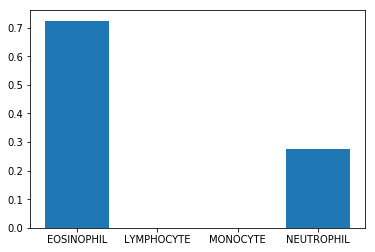

'EOSINOPHIL'

In [17]:
predict('dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg',model)

In [51]:
model

NeuralNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=4, bias=True)
  (dropout): Dropout(p=0.25)
  (softmax): LogSoftmax()
)